# Food Scanner - Soil Data

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from IPython.display import display

from module_utils.utils import describe_plus, r2, quantile, plot_dist, plot_mean_std
from module_utils.model_training import plot_mae_and_predict, train_model,\
                                        compute_losses_reg, compute_losses_train_test_reg
from module_utils.scoreRegression import scoreClassif, scoreClassifier

sns.set()
warnings.filterwarnings('ignore')
np.set_printoptions(precision=2)

## Import File

In [2]:
df = pd.read_csv('Soil-Food.csv', sep = ',')
df.rename(columns={"carrots.veg_results.data.proteinMgPer100g": "Carrots protein (mg/100g)",
                   "carrots.veg_results.data.polyphenolsMgGae100gFw": "Carrots polyphenols (mg/100g)",
                   "carrots.veg_results.data.antioxidentsFrap" : "Carrots antioxidants (µmol/100g)",
                  "spinach.veg_results.data.proteinMgPer100g": "Spinach protein (mg/100g)",
                   "spinach.veg_results.data.polyphenolsMgGae100gFw": "Spinach polyphenols (mg/100g)",
                  "spinach.veg_results.data.antioxidentsFrap": "Spinach antioxidants (µmol/100g)"}, inplace=True)

### Independent variables
#### The first 5 lines of dataframe which represents the absorption of carrots and spinach according to the wavelength (in nm)

In [3]:
df_preview_sample = df[["carrots.carrotscan.median_500", "carrots.carrotscan.median_530", "spinach.spinachscan.median_850", "spinach.spinachscan.median_880"]].copy(deep=True)
df_preview_sample.head()

carrots.carrotscan.median_500  carrots.carrotscan.median_530  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                       4.640765                       6.752740   
3                       2.274004                       5.964625   
4                            NaN                            NaN   

   spinach.spinachscan.median_850  spinach.spinachscan.median_880  
0                       40.661500                       43.661500  
1                       40.747533                       43.373233  
2                             NaN                             NaN  
3                             NaN                             NaN  
4                             NaN                             NaN

### Dependent variables
#### The first 5 lines of dataframe which represents the nutritional values of carrots and spinach

In [4]:
df_preview_target = df[["Carrots protein (mg/100g)", "Carrots polyphenols (mg/100g)", "Carrots antioxidants (µmol/100g)", "Spinach protein (mg/100g)", "Spinach antioxidants (µmol/100g)"]].copy(deep=True)
df_preview_target.head()

Carrots protein (mg/100g)  Carrots polyphenols (mg/100g)  \
0                        NaN                            NaN   
1                        NaN                            NaN   
2                       1.70                           2.38   
3                       1.94                           3.62   
4                        NaN                            NaN   

   Carrots antioxidants (µmol/100g)  Spinach protein (mg/100g)  \
0                               NaN                       2.18   
1                               NaN                       4.28   
2                             14.43                        NaN   
3                             20.65                        NaN   
4                               NaN                        NaN   

   Spinach antioxidants (µmol/100g)  
0                            294.49  
1                            168.33  
2                               NaN  
3                               NaN  
4                               NaN

## In-depth analysis
### Correlation beetween carbon/soil respiration/mineral in top soil vs bottom soil
#### Soil copper and soil respiration

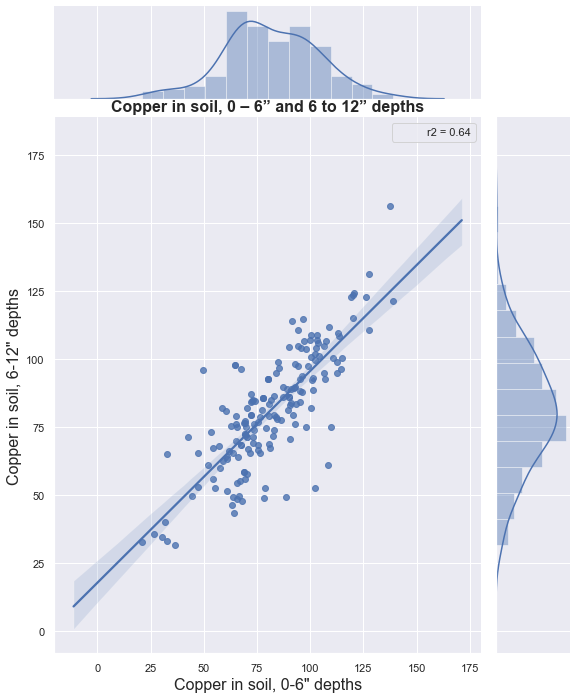

In [5]:
sns.jointplot(x='soil_0_15_Cu', y='soil_15_30_Cu', data=df, kind='reg', stat_func=r2, height=8)
plt.subplots_adjust(top=1.2)
plt.xlabel('Copper in soil, 0-6" depths', fontsize=16)
plt.ylabel('Copper in soil, 6-12" depths', fontsize=16)
_ = plt.title('Copper in soil, 0 – 6” and 6 to 12” depths', fontsize=16, weight='bold')

#### Soil potassium and soil respiration

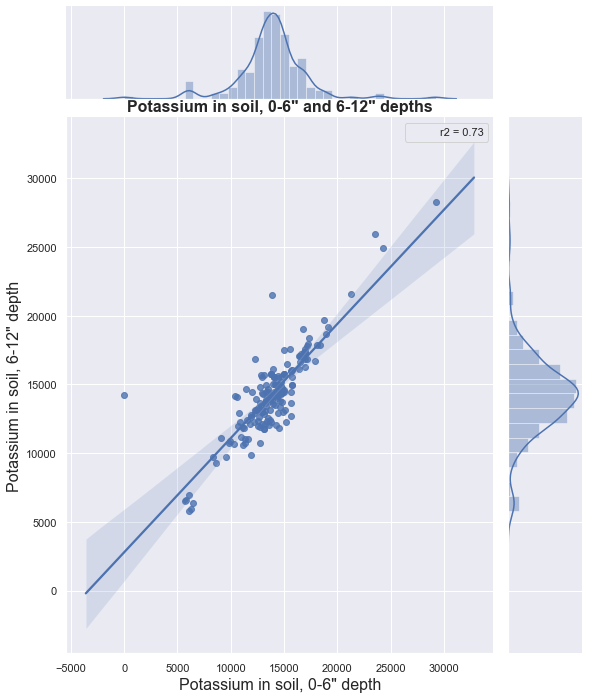

In [6]:
sns.jointplot(x='soil_0_15_K', y='soil_15_30_K', data=df, stat_func=r2, kind='reg', height=8)
plt.subplots_adjust(top=1.2)
plt.xlabel('Potassium in soil, 0-6" depth', fontsize=16)
plt.ylabel('Potassium in soil, 6-12" depth', fontsize=16)
_ = plt.title('Potassium in soil, 0-6" and 6-12" depths', fontsize=16, weight='bold')

#### Soil carbon and soil respiration

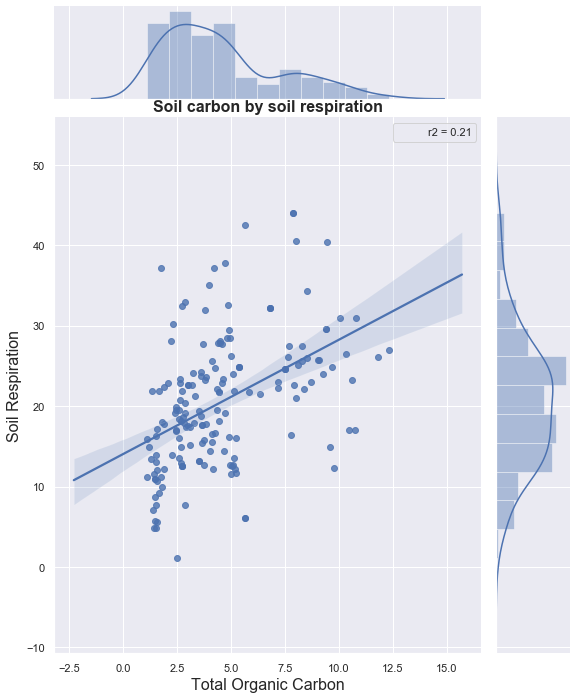

In [7]:
sns.jointplot(x='soil3.display_loi.data.Total Organic C %', y='soil3.display_respiration.data.ugc_gsoil', data=df, stat_func=r2, kind="reg", height=8)
plt.subplots_adjust(top=1.2)
plt.xlabel('Total Organic Carbon', fontsize=16)
plt.ylabel('Soil Respiration', fontsize=16)
_ = plt.title('Soil carbon by soil respiration', fontsize=16, weight='bold')

In [8]:
sns.jointplot(x='soil9.display_loi.data.Total Organic C %', y='soil9.display_respiration.data.ugc_gsoil', data=df, stat_func=r2, kind="reg", height=8)
plt.subplots_adjust(top=1.2)
plt.xlabel('Total Organic Carbon', fontsize=16)
plt.ylabel('Soil Respiration', fontsize=16)
_ = plt.title('Soil carbon by soil respiration', fontsize=16, weight='bold')

#### Polyphenols and antioxidants

We created a dataframe with the total amount of polyphenols and antioxidants (in carrots and spinach) to see if there's a correlation.

In [9]:
df_poly_anti = pd.concat([df['Carrots polyphenols (mg/100g)'].fillna(0) + df['Spinach polyphenols (mg/100g)'].fillna(0),
           df['Carrots antioxidants (µmol/100g)'].fillna(0) + df['Spinach antioxidants (µmol/100g)'].fillna(0)], axis=1)
df_poly_anti.replace(0.00, np.nan, inplace=True)
df_poly_anti.rename(columns={0: "Polyphenols", 1: "Antioxidants"}, inplace=True)

In [10]:
sns.jointplot(x='Polyphenols', y='Antioxidants', data=df_poly_anti, stat_func=r2, kind='reg', height=8)
plt.subplots_adjust(top=1.2)
plt.xlabel('Polyphenols', fontsize=16)
plt.ylabel('Antioxidants', fontsize=16)
_ = plt.title('Antioxidants by Polyphenols, carrots and spinach', fontsize=16, weight='bold')

#### Antioxidants and soil respiration
We create a dataframe with the total amount of antioxidants and soil respiration to see if they are correlated.

In [11]:
df_anti_soilresp = pd.concat([df['soil3.display_loi.data.Total Organic C %'].fillna(0) + df['soil9.display_loi.data.Total Organic C %'].fillna(0),
           df['Carrots antioxidants (µmol/100g)'].fillna(0) + df['Spinach antioxidants (µmol/100g)'].fillna(0)], axis=1)
df_anti_soilresp.replace(0.00, np.nan, inplace=True)
df_anti_soilresp.rename(columns={0: "Soil Respiration", 1: "Antioxidants"}, inplace=True)

In [12]:
sns.jointplot(x='Soil Respiration', y='Antioxidants', data=df_anti_soilresp, stat_func=r2, kind='reg', height=8)
plt.subplots_adjust(top=1.2)
plt.xlabel('Soil Respiration', fontsize=16)
plt.ylabel('Antioxidants', fontsize=16)
_ = plt.title('Antioxidants by Soil Respiration, carrots and spinach', fontsize=16, weight='bold')

## Model Algorithm
The available data we have to predict the nutritional value of carrots and spinach are essentially quantitative variables, which is why we turn to a regression model. We'll use RandomForest Regressor and Linear Regression. Then we will direct the project towards a classification problem, by training the model to classify vegetables (carrots and spinach) as rich or poor in nutrients. For this we will use the Random Forest Classifier as classification algorithm. The goal is to compare the performances of the regression model and the classification model.

### Variables to predict
Now we are going to visualize our independent variables (those to predict), according to carrots and spinach:
- **polyphenol** (mg/100g)
- **protein** (mg/100g)
- **antioxidant** (µmol/100g)

In [13]:
# group the target variables and plot the distribution
df_target_carrots = df[['Carrots polyphenols (mg/100g)', 'Carrots protein (mg/100g)', 'Carrots antioxidants (µmol/100g)']]
df_target_spinach = df[['Spinach polyphenols (mg/100g)', 'Spinach protein (mg/100g)', 'Spinach antioxidants (µmol/100g)']]

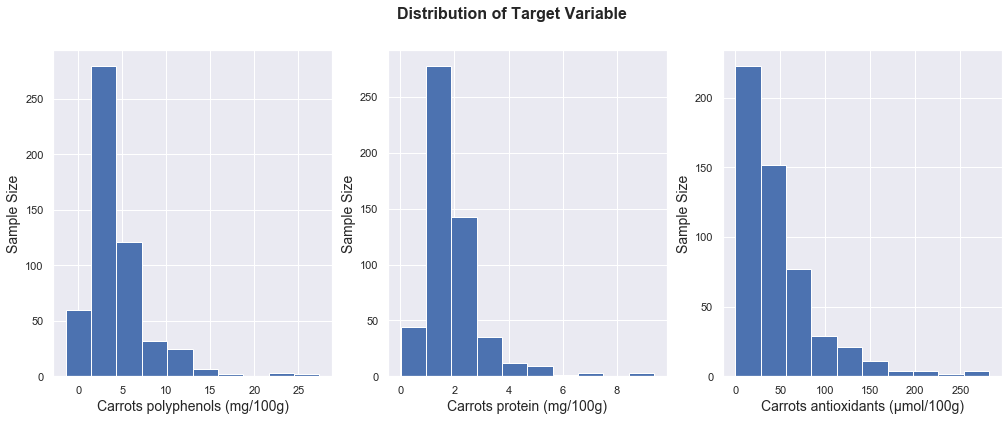

In [14]:
# plot histogram for each columns of the dataframe
plot_dist(df_target_carrots)
plot_dist(df_target_spinach)

### Features
Then, we create a dataframe with the spectral data of the Bionutrient Meter Beta coming from carrots and spinach (10 wavelengths from 365 nm to 940 nm). It is only on this data that we will work for the moment to predict the nutritional values of carrots and spinach.

#### Carrots

In [15]:
df_carrotscan = df[["carrots.carrotscan.median_365", "carrots.carrotscan.median_385", "carrots.carrotscan.median_450", "carrots.carrotscan.median_500", "carrots.carrotscan.median_530", "carrots.carrotscan.median_587", "carrots.carrotscan.median_632", "carrots.carrotscan.median_850", "carrots.carrotscan.median_880", "carrots.carrotscan.median_940"]]
df_carrotscan.rename(columns={"carrots.carrotscan.median_365": "365",
                              "carrots.carrotscan.median_385": "385",
                              "carrots.carrotscan.median_450": "450",
                              "carrots.carrotscan.median_500": "500",
                              "carrots.carrotscan.median_530": "530",
                              "carrots.carrotscan.median_587": "587",
                              "carrots.carrotscan.median_632": "632",
                              "carrots.carrotscan.median_850": "850",
                              "carrots.carrotscan.median_880": "880",
                              "carrots.carrotscan.median_940": "940"}, inplace=True)
df_target_carrots_describe = describe_plus(df_target_carrots)
display(df_target_carrots_describe)

count   mean    std   min     max    25%  \
Carrots polyphenols (mg/100g)     532.0   4.41   3.46 -1.42   27.39   2.41   
Carrots protein (mg/100g)         528.0   1.92   1.08  0.01    9.37   1.34   
Carrots antioxidants (µmol/100g)  527.0  48.18  44.87 -0.02  281.82  19.76   

                                    50%    75%  
Carrots polyphenols (mg/100g)      3.52   5.24  
Carrots protein (mg/100g)          1.70   2.19  
Carrots antioxidants (µmol/100g)  32.93  61.83

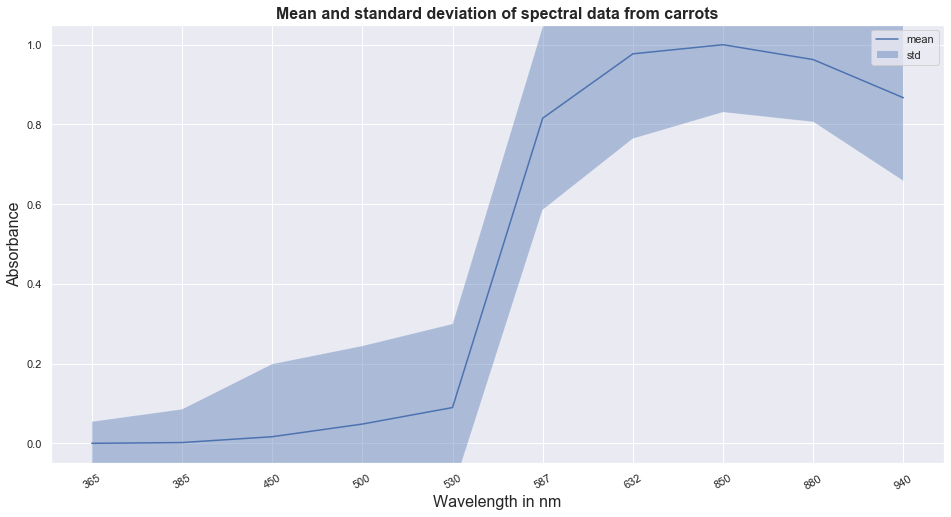

In [16]:
plot_mean_std(df_carrotscan, 'Wavelength in nm', 'Absorbance', 'Mean and standard deviation of spectral data from carrots')

#### Spinach

In [17]:
df_spinachscan = df[["spinach.spinachscan.median_365", "spinach.spinachscan.median_385", "spinach.spinachscan.median_450", "spinach.spinachscan.median_500", "spinach.spinachscan.median_530", "spinach.spinachscan.median_587", "spinach.spinachscan.median_632", "spinach.spinachscan.median_850", "spinach.spinachscan.median_880", "spinach.spinachscan.median_940"]]
df_spinachscan.rename(columns={"spinach.spinachscan.median_365": "365",
                              "spinach.spinachscan.median_385": "385",
                              "spinach.spinachscan.median_450": "450",
                              "spinach.spinachscan.median_500": "500",
                              "spinach.spinachscan.median_530": "530",
                              "spinach.spinachscan.median_587": "587",
                              "spinach.spinachscan.median_632": "632",
                              "spinach.spinachscan.median_850": "850",
                              "spinach.spinachscan.median_880": "880",
                              "spinach.spinachscan.median_940": "940"}, inplace=True)
df_target_spinach_describe = describe_plus(df_target_spinach)
display(df_target_spinach_describe)

count    mean     std    min      max  \
Spinach polyphenols (mg/100g)     108.0   50.04   37.10   4.31   331.76   
Spinach protein (mg/100g)         100.0    5.90    6.20   0.84    26.16   
Spinach antioxidants (µmol/100g)  108.0  383.38  398.82  25.06  2974.90   

                                    25%     50%     75%  
Spinach polyphenols (mg/100g)     26.69   52.10   64.53  
Spinach protein (mg/100g)          3.38    4.14    4.79  
Spinach antioxidants (µmol/100g)  56.56  272.32  647.82

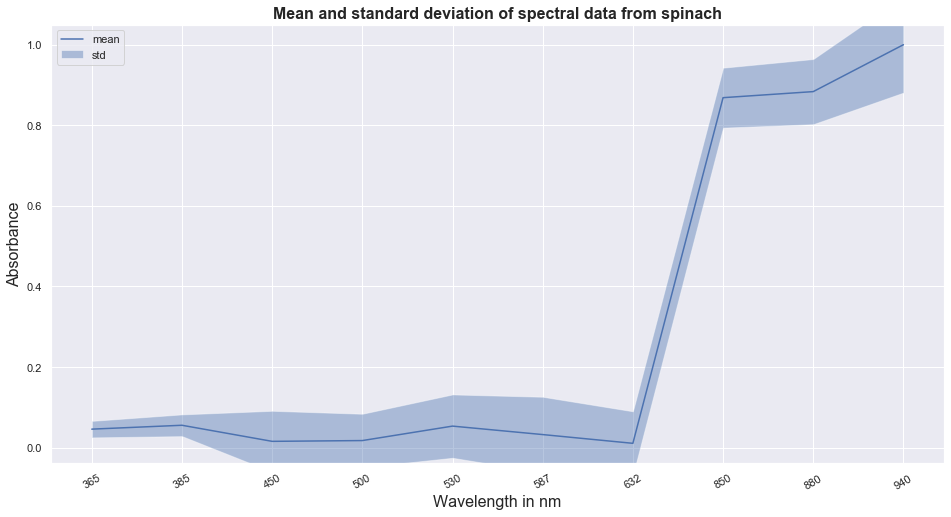

In [18]:
plot_mean_std(df_spinachscan, 'Wavelength in nm', 'Absorbance', 'Mean and standard deviation of spectral data from spinach')

## Carrot sample - Training models
We are going to use the spectral data from the Bionutrient Meter (10 wavelengths from 365nm to 940nm) from our carrots samples to feed our learning algorithms. First we are going to use 2 regression algorithms : Linear Regression and Random Forest Regressor. Then we will use a classification algorithm : Random Forest Classifier.

For each of our learning algorithms we are going to compute metrics to determine which of them is the most performant on this specific data set.

In [19]:
# remove all missing values from the carrots dataframe
df_carrots_raw = pd.concat([df_carrotscan, df_target_carrots], axis=1 ,sort=False)
df_carrots_noNA = df_carrots_raw.dropna()

### Random Forest Regressor
We use a Random Forest Regressor model to try to predict the nutritional value of carrots in terms of polyphenol, protein and antioxidant based on spectral data.

In [20]:
# Independent variables
x = df_carrots_noNA[df_carrots_noNA.columns[:-3]].values
# variables to predict (the 3 nutrients)
y = df_carrots_noNA[df_carrots_noNA.columns[-3:]].values

In [21]:
# We split the dataset into training set and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (352, 10)
Training Labels Shape: (352, 3)
Testing Features Shape: (151, 10)
Testing Labels Shape: (151, 3)


In [22]:
# Define the model
RF_regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
# Train model with Random Forest Regressor
train_model(RF_regressor, x_train, y_train)

Here we compute the loss metrics of the Random Forest Regressor algorithm on carrots testing set. So we obtain a dataframe including mae, mse, rmse, r2 and Score classifier metrics. We display the errors made by the model and the predicted values compared to the observed values.

Then we display two plots: the first is to visualize the error made by the model on the 3 nutrients. The second is to see the distribution of the predicted values compared to the observed values.

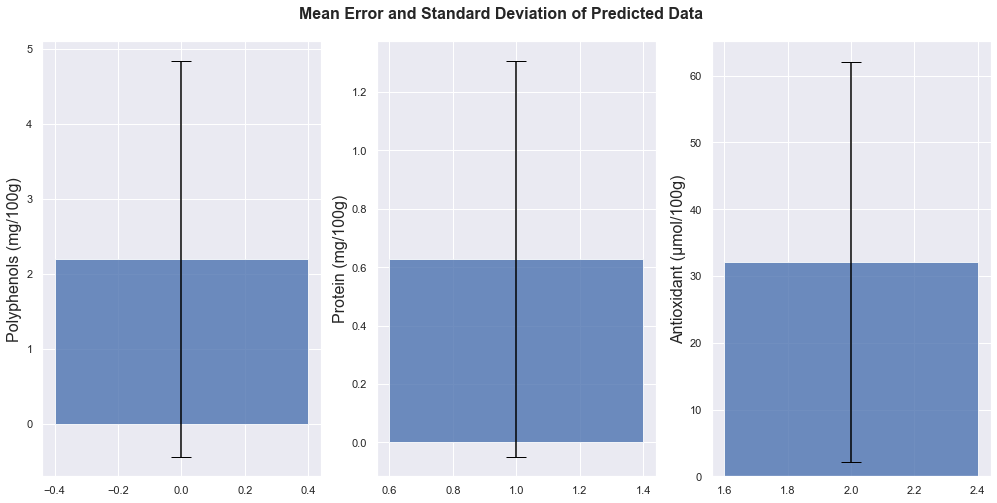

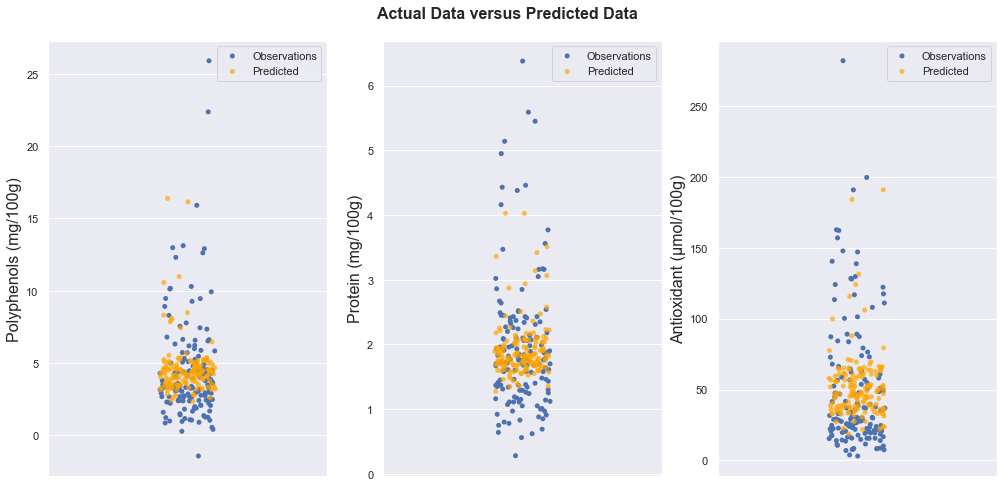

In [23]:
# evaluate model
# compute metrics
resume_metrics_rfr = compute_losses_reg(RF_regressor, x_test, y_test)

# ordinate axis labels
nutriments_units = ['Polyphenols (mg/100g)', 'Protein (mg/100g)', 'Antioxidant (µmol/100g)']
#plot mae and predicted variables
plot_mae_and_predict(model = RF_regressor,
                x = x_test,
                y = y_test,
                ylabel = nutriments_units)

### Linear Regression
We use a Linear Regression model to try to predict the nutritional value of carrots in terms of polyphenol, protein and antioxidant based on spectral data.

In [24]:
# Define the model
lin_regression = LinearRegression()
train_model(lin_regression, x_train, y_train)

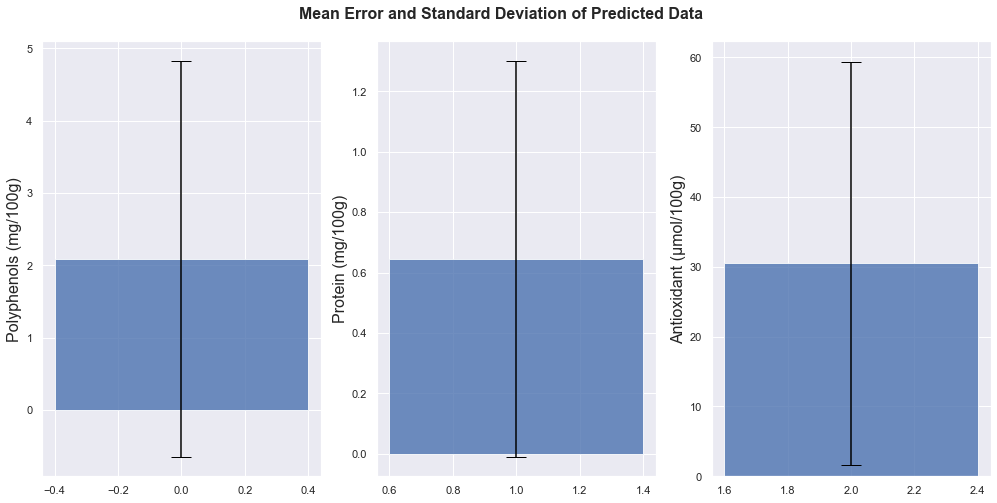

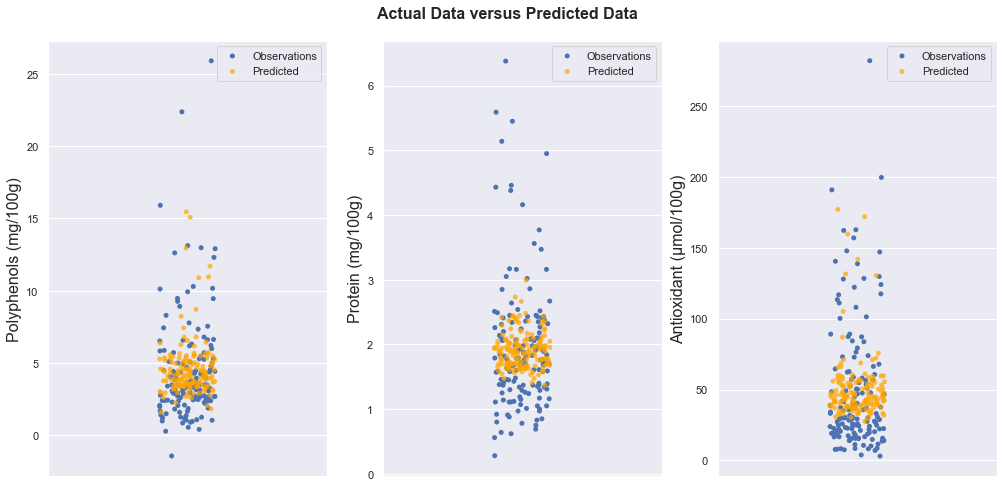

In [25]:
# evaluate model
# compute metrics
resume_metrics_lin = compute_losses_reg(lin_regression, x_test, y_test)

# plot mae and predicted variables
plot_mae_and_predict(model = lin_regression,
                x = x_test,
                y = y_test,
                ylabel = nutriments_units)

### Random Forest Classifier

Then we use Random Forest Classifier algorithm, not to predict the exact nutritional value of vegetables, but to determine whether a carrot (and spinach) is rich or poor in nutrients. In order for the model to be able to classify, we establish a threshold which is the median of the nutrient values (32.73 for the antioxidant). Thus, a value below the threshold will be of class 0 (poor) and 1 for vegetables being above the threshold (rich).

In [26]:
# Minimally prepare dataset
# Independent variables
x = df_carrots_noNA[df_carrots_noNA.columns[:-3]].values
# variable to predict (antioxidant only because Random Forest Classifier can only take 1 output variable)
y = quantile(df_carrots_noNA[df_carrots_noNA.columns[-1:]].values)

In [27]:
# We split the dataset into training set (to train the model) and testing set (to evaluate the model)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (352, 10)
Training Labels Shape: (352, 1)
Testing Features Shape: (151, 10)
Testing Labels Shape: (151, 1)


In [28]:
# Define the model
classifier = RandomForestClassifier(n_estimators=1000)
train_model(classifier, x_train, y_train)

In [29]:
# predict whether the carrot is rich or poor in nutrient
# We get a score by looking where the model was right, how many times has the model correctly classified
score_classifier = scoreClassifier(classifier, x_test, y_test)

### Comparison of the 3 learning algorithms on carrots dataset

In [30]:
# Report performances
df_resume_performance_carrot = pd.DataFrame.from_dict({
    'Linear Regression': resume_metrics_lin,
    'RandomForest Regressor': resume_metrics_rfr,
    'RandomForest Classifier': np.nan
    })
df_resume_performance_carrot['RandomForest Classifier'].loc['Score Classifier'] = score_classifier
df_resume_performance_carrot.fillna('', inplace=True)
df_resume_performance_carrot

Linear Regression  RandomForest Regressor  \
MAE                       11.071481               11.647704   
MSE                      591.216511              646.383389   
RMSE                      24.314944               25.424071   
R2                         0.148209                0.068728   
Score Classifier           0.540839                0.518764   

                 RandomForest Classifier  
MAE                                       
MSE                                       
RMSE                                      
R2                                        
Score Classifier                0.609272

We compare our 3 models to see if they can determine whether a carrot is rich in nutrients or not (polyphenols, protein, antioxidant). Our RandomForest Regressor obtains a R2 of 0.06 and our Linear Regression does better by obtaining 0.14 at the R2.

By comparing the results of the three models based on the Score Classifier, we find that better performance are obtained using a RandomForest Classifier - to predict whether a carrot will be good or bad in nutritional value.

Concerning the Score Classifier metric, we create a function that measures the performance of our regression algorithms on a classification problem. We tried to determine how well our regression model had predicted the nutritional values, by classifying the carrots as being poor or rich in nutrients (polyphenol, antioxidant, protein). For this, we established a threshold based on the 50th quantile of the observed values.

## Spinach sample - Training models

We are going to proceed with the same steps as before but this time on data from spinach, that is to say use the spectral data for the learning of our regression and classification models, then evaluate them and finally compare their performance. For each of our learning algorithms we are going to compute metrics to determine which of them is the most performant on this specific data set.

In [31]:
# remove all missing values from the carrots dataframe
df_spinach_raw = pd.concat([df_spinachscan, df_target_spinach], axis=1 ,sort=False)
df_spinach_noNA = df_spinach_raw.dropna()

### Random Forest Regressor

In [32]:
x = df_spinach_noNA[df_spinach_noNA.columns[:-3]].values
y = df_spinach_noNA[df_spinach_noNA.columns[-3:]].values

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (68, 10)
Training Labels Shape: (68, 3)
Testing Features Shape: (30, 10)
Testing Labels Shape: (30, 3)


In [34]:
# define the model
RF_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
train_model(RF_regressor, x_train, y_train)

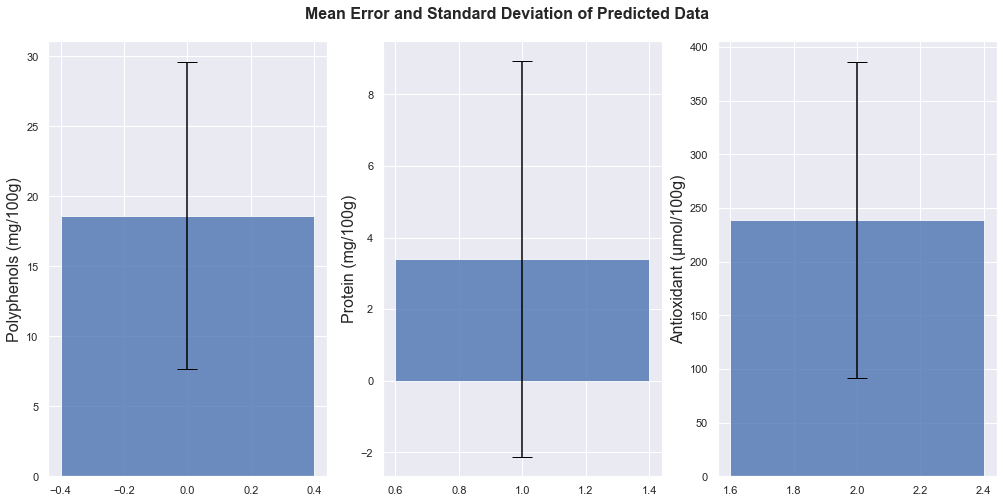

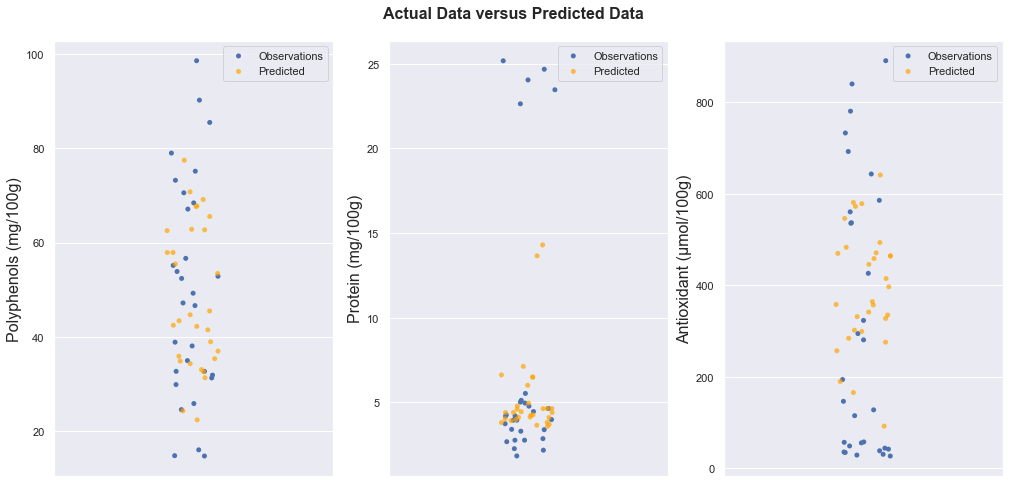

In [35]:
# evaluate model
# compute metrics and plot the errors made by the model and the predicted values compared to the observed values
resume_metrics_rfr = compute_losses_train_test_reg(model = RF_regressor,
                             x_train = x_train,
                             y_train = y_train,
                             x_test = x_test,
                             y_test = y_test)
resume_metrics_rfr.rename(columns={"Train": "RForest Regressor Train",
                                   "Test": "RForest Regressor Test"}, inplace=True)

#plot mae and predicted variables
plot_mae_and_predict(model = RF_regressor,
                x = x_test,
                y = y_test,
                ylabel = nutriments_units)

### Linear Regression

In [36]:
# Define the model
lin_regression = LinearRegression()
train_model(lin_regression, x_train, y_train)

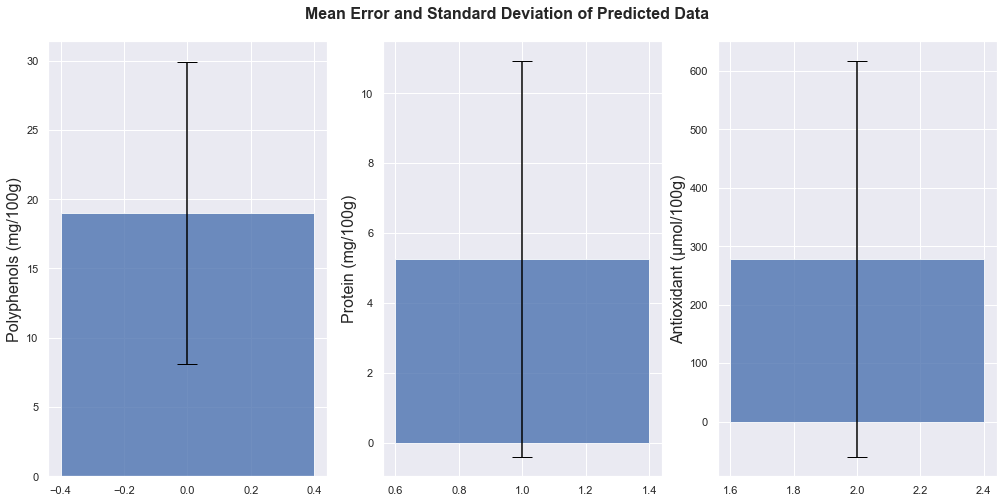

In [37]:
# evaluate model
# compute metrics and plot the errors made by the model and the predicted values compared to the observed values
resume_metrics_lin = compute_losses_train_test_reg(model = lin_regression,
                             x_train = x_train,
                             y_train = y_train,
                             x_test = x_test,
                             y_test = y_test)
resume_metrics_lin.rename(columns={"Train": "Linear Regression Train", "Test": "Linear Regression Test"}, inplace=True)

#plot mae and predicted variables
plot_mae_and_predict(model = lin_regression,
                x = x_test,
                y = y_test,
                ylabel = nutriments_units)

### Random Forest Classifier

In [38]:
# Independent variables
x = df_spinach_noNA[df_spinach_noNA.columns[:-3]].values
# Variable to predict (antioxidant only)
y = quantile(df_spinach_noNA[df_spinach_noNA.columns[-1:]].values)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (68, 10)
Training Labels Shape: (68, 1)
Testing Features Shape: (30, 10)
Testing Labels Shape: (30, 1)


In [40]:
# Define the model
classifier = RandomForestClassifier(n_estimators=1000)
train_model(classifier, x_train, y_train)

In [41]:
# predict whether the carrot is rich or poor in nutrient
# We get a score by looking where the model was right, how many times has the model correctly classified
score_classifier = scoreClassifier(classifier, x_test, y_test)

### Comparison of the 3 learning algorithms on spinach dataset

In [42]:
df_resume_performance_spinach = pd.concat([resume_metrics_lin, resume_metrics_rfr], axis=1)
df_resume_performance_spinach.insert(4, "Random Forest Classifier", [np.nan, np.nan, np.nan, np.nan, score_classifier])
df_resume_performance_spinach.fillna('', inplace=True)
df_resume_performance_spinach

Linear Regression Train  Linear Regression Test  \
MAE                             69.964061              100.900334   
MSE                          19235.321732            64166.645762   
RMSE                           138.691462              253.311361   
R2                               0.405606               -1.286898   
Score Classifier                 0.622549                0.655556   

                  RForest Regressor Train  RForest Regressor Test  \
MAE                             31.061594               86.980749   
MSE                           3746.876220            26405.740931   
RMSE                            61.211733              162.498434   
R2                               0.884217                0.058900   
Score Classifier                 0.848039                0.655556   

                 Random Forest Classifier  
MAE                                        
MSE                                        
RMSE                                       
R2                                         
Score Classifier                 0.633333

Regarding the difference in results between the training set and the testing set for Linear Regression and Random Forest Regressor for the spinash data set, we can assume that we do not have enough data to allow the algorithms to understand the data and therefore the models fail to generalize.